In [1]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from pillow_heif import open_heif
import scipy.stats


def read_image(path, scale=1 / 4):
    try:
        if Path(path).suffix.lower() == ".heic":
            img = open_heif(path, convert_hdr_to_8bit=True)
        else:
            img = Image.open(path)
        rgb = np.asarray(img)
        H, W = rgb.shape[:-1]
        new_H = int(H * scale)
        new_W = int(W * scale)
    except:
        print(path)
        raise
    return cv2.resize(rgb, (new_W, new_H))

def extract_mask(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l = lab[:, :, 0] / 255
    rb_mask = img[:, :, 0] > img[:, :, 2]
    bg_l = scipy.stats.mode(l.reshape(-1)).mode
    cont_mask = (np.abs(l - bg_l) / bg_l) 
    dab_cont_mask = cont_mask * rb_mask
    h_cont_mask = cont_mask * (~rb_mask)
    return dab_cont_mask, h_cont_mask

def count_hole(mask, min_area=100):
    h, w = mask.shape
    analysis = cv2.connectedComponentsWithStats(((~mask) * 255).astype(np.uint8), 
                                                4, 
                                                cv2.CV_32S) 
    (totalLabels, label_ids, values, centroid) = analysis 
    
    # Loop through each component 
    count = 0
    for i in range(1, totalLabels): 
        area = values[i, cv2.CC_STAT_AREA]   
        if (area > min_area) and (area < h * w / 100): 
            count += 1
    return count


def count_cell(h_mask, min_area=200):
    prep_h_mask = np.round(h_mask / h_mask.max() * 255).astype(np.uint8)
    h, w = prep_h_mask.shape
    analysis = cv2.connectedComponentsWithStats(((prep_h_mask > 5) * 255).astype(np.uint8), 
                                                4, 
                                                cv2.CV_32S) 
    (totalLabels, label_ids, values, centroid) = analysis 
    # Loop through each component 
    h_count = 0
    for i in range(1, totalLabels): 
        area = values[i, cv2.CC_STAT_AREA]   
        if (area > min_area) and (area < h * w / 100): 
            h_count += 1
    return h_count

Text(0.5, 1.0, 'cell: 1')

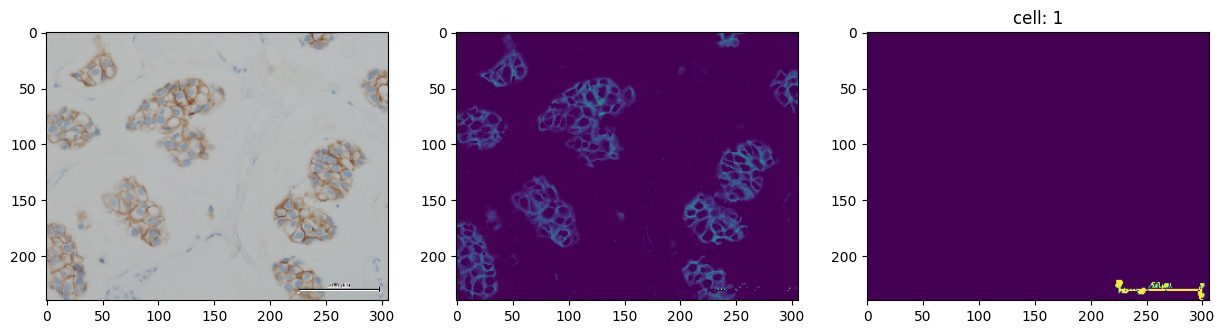

In [7]:
path = "/home/surayuth/her2/Data_Chula/30 Nov 23 HER2 2+ D+ 04/04 HER2 2+ D+ (34).JPG"
#path = "/home/surayuth/her2/Data_Chula/21 Sep HER2 score 0 case 2/HER2 score 0 case 2 (3).JPG"
#path = "/home/surayuth/her2/Data_Chula/16 April HER2 3+ D+_1/Her2 3+ D+ (1).jpg"
img = read_image(path, scale=0.25)
cont_mask, h_cont_mask = extract_mask(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(img)
ax2.imshow(cont_mask)

prep_h_mask = h_cont_mask > 0.05 #np.round(h_cont_mask / h_cont_mask.max() * 255).astype(np.uint8)
h, w = prep_h_mask.shape
analysis = cv2.connectedComponentsWithStats((prep_h_mask).astype(np.uint8), 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 
output = np.zeros_like(label_ids)
# Loop through each component 
h_count = 0
for i in range(1, totalLabels): 
    area = values[i, cv2.CC_STAT_AREA]   
    if (area > 200) and (area < h * w / 100): 
        h_count += 1
        output[label_ids == i] = 255

ax3.imshow(output)
ax3.set_title(f"cell: {h_count}")

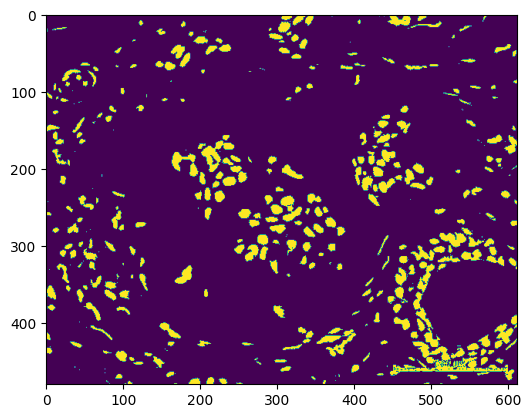

In [3]:
plt.imshow(h_cont_mask > 0.05)

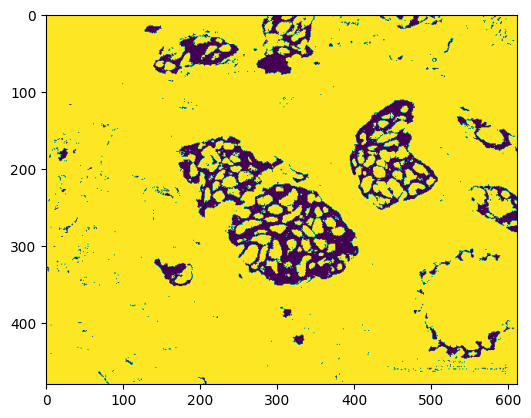

In [4]:
prep_mask = np.round(cont_mask / cont_mask.max() * 255).astype(np.uint8)
plt.imshow(prep_mask < 10)

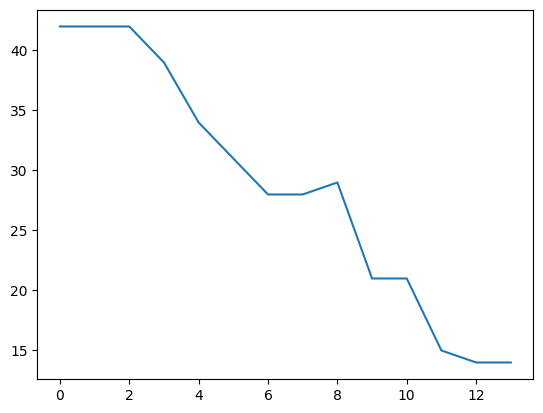

In [5]:
prep_mask = np.round(cont_mask / cont_mask.max() * 255).astype(np.uint8)
min_hole = 10

holes = []
for i in range(1, 255):
    holes.append(count_hole(prep_mask > i))

holes = np.array(holes)
holes = holes[holes > min_hole][np.argmax(holes):]
plt.plot(np.arange(len(holes)), holes)

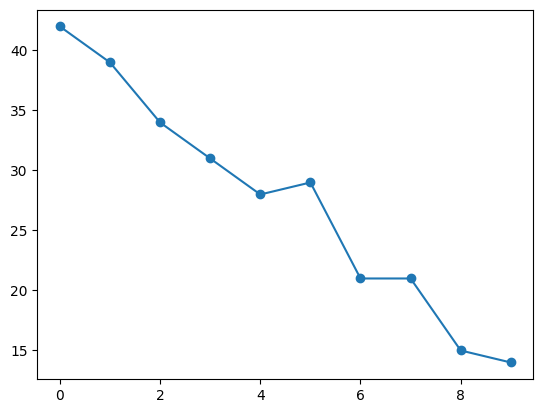

In [6]:
min_hole = 10

holes = []
for i in np.arange(0.01, 1, .005):
    holes.append(count_hole(cont_mask > i))

holes = np.array(holes)
holes = holes[holes > min_hole][np.argmax(holes):]
plt.plot(np.arange(len(holes)), holes, marker="o")

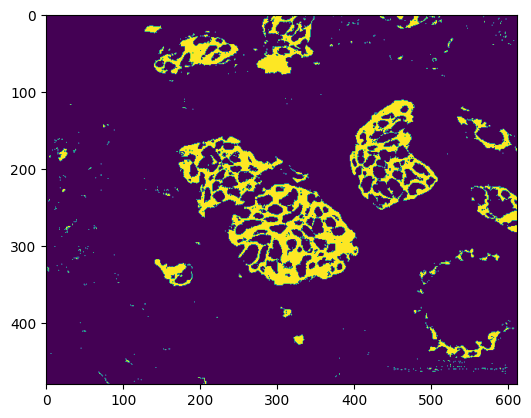

In [7]:
plt.imshow(prep_mask > 10)

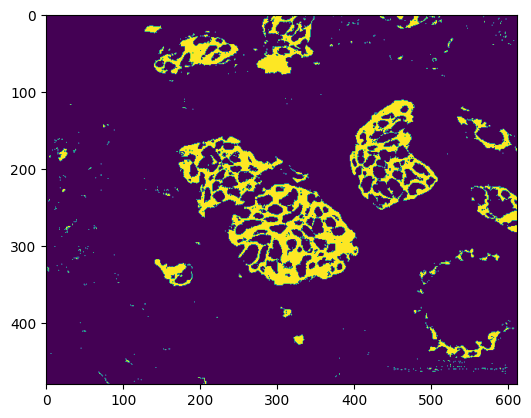

In [8]:
plt.imshow(cont_mask > 0.04)